<a href="https://colab.research.google.com/github/Mai-Binh-Nam/Hand-on_DataAnalysisVEF/blob/master/%5BStudents%5D_Lecture_03_Linear_Regression_Shipping_fee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Linear Regression to predict product's shipping fee

## Import Library & Data

In [ ]:
# Library to calculate distance between 2 points using lat-long coordinates
!pip install haversine

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
# Option to specify the default size of plots by seaborn. A4 size
sns.set(rc={'figure.figsize':(11.7,8.27)})

from haversine import haversine, Unit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Orders
orders = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_orders_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_order_reviews_dataset.csv')
order_payments = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_order_payments_dataset.csv')

# Customers and Sellers
customers = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_customers_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_sellers_dataset.csv')

# Products and Categories
products = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/olist_products_dataset.csv')
product_translation = pd.read_csv('https://raw.githubusercontent.com/thuynh386/olist_ecommerce_dataset/master/product_category_name_translation.csv')

geolocation = pd.read_csv("https://github.com/pnhuy/datasets/blob/master/brazilian_ecommerce/data/olist_geolocation_dataset.csv.zip?raw=true", compression="zip")

## Data Exploration to understand the dataset

See the excel file [here](https://docs.google.com/spreadsheets/d/1KawVe57InaVnU19MVwutDzfMBHG6zDLZwDa3-zzu360/edit?usp=sharing)

## Question

Because the platform hasn't handled delivery by themselves, sellers will decide the shipping fee for their products. We are concerned that some sellers might take advantage of it to set the product display price low but put extra in shipping fee to cover for the low price.

In order to detect such sellers, we first need to understand what explains the shipping fee applied by sellers.

## Define dependent variable and independent variables (or features) for Linear Regression

Think about potential independent variables which can impact shipping fee.

Independent variables:
1. Distance 
1. Delivery vendor
1. Weight
1. Item value
1. Shipping hour
1. Urgency
1. Insurance
1. Domestic vs. International
1. Crude oil price
1. Volume
1. Urban vs Rural
1. Item return

Approach: Linear Regression.

--> Data format needed.

### Customer & Seller location by zip code prefix

In [ ]:
customers.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 5 columns]

In [ ]:
customers.groupby("customer_id")["customer_zip_code_prefix"].nunique()\
.reset_index().sort_values("customer_zip_code_prefix", ascending=False)

customer_id  customer_zip_code_prefix
0      00012a2ce6f8dcda20d059ce98491703                         1
66279  aa62a16b10e3fb24ecdefd7e4dc3fa65                         1
66301  aa738cdb72af39e38482fa25b992c67c                         1
66300  aa7210736aad65a84e964cfa8d64aa66                         1
66299  aa72002446dfbac0691304465c1b982d                         1
...                                 ...                       ...
33144  5591abc9e7f9c644e7e7912aac65b718                         1
33143  5590e685a78102fb3ac27ecf07412750                         1
33142  558ea29f4c4dfd014345b6d3309549a2                         1
33141  558de2f6863bf7588338479d614522a3                         1
99440  ffffe8b65bbe3087b653a978c870db99                         1

[99441 rows x 2 columns]

So, each customer has only one zip code prefix. Do the same for sellers to see if they also have only one zip code prefix.

In [ ]:
sellers.groupby("seller_id")["seller_zip_code_prefix"].nunique()\
.reset_index().sort_values("seller_zip_code_prefix", ascending=False)


seller_id  seller_zip_code_prefix
0     0015a82c2db000af6aaaf3ae2ecb0532                       1
2032  a7a9b880c49781da66651ccf4ba9ac38                       1
2058  aadfe0417e61315688b6bd7043361e25                       1
2059  aae3bfea055532c57fb453ed3ec80b30                       1
2060  aae5953b9edddf14749c0d65d60eb4b9                       1
...                                ...                     ...
1034  54aa8463e87776b5612f4bdc4bd5d4de                       1
1035  54c04bdb5ec46762f8f08c7e8f86ed4a                       1
1036  55029529919c0123526150bd26ca8f20                       1
1037  553a440137d6e0cf776aee0bb83ac9f5                       1
3094  ffff564a4f9085cd26170f4732393726                       1

[3095 rows x 2 columns]

Now check the geolocation table. We will see that for each zip code prefix, we have multiple pairs of long-lat as it can point to different locations within the same city. 

In order to calculate the distance between customers and sellers, we will average out long-lat for each prefix and use that as the approximate long-lat values.

In [ ]:
geolocation.head()

geolocation_zip_code_prefix  ...  geolocation_state
0                         1037  ...                 SP
1                         1046  ...                 SP
2                         1046  ...                 SP
3                         1041  ...                 SP
4                         1035  ...                 SP

[5 rows x 5 columns]

In [ ]:
geolocation.groupby("geolocation_zip_code_prefix").agg({"geolocation_lat":"nunique",
                                                        "geolocation_lng":"nunique"}).reset_index()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                             1001               10               10
1                             1002                6                6
2                             1003               10               10
3                             1004               14               14
4                             1005               11               11
...                            ...              ...              ...
19010                        99960                5                5
19011                        99965                6                6
19012                        99970               16               16
19013                        99980               21               21
19014                        99990                2                2

[19015 rows x 3 columns]

In [ ]:
zip_code_prefix = geolocation.groupby("geolocation_zip_code_prefix").agg({"geolocation_lat":"mean",
                                                                   "geolocation_lng":"mean"}).reset_index()

zip_code_prefix.head()                                                           

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550190       -46.634024
1                         1002       -23.548146       -46.634979
2                         1003       -23.548994       -46.635731
3                         1004       -23.549799       -46.634757
4                         1005       -23.549456       -46.636733

In [ ]:
zip_code_prefix.rename(columns={"geolocation_zip_code_prefix":"zip_code",
                                "geolocation_lat":"avg_lat",
                                "geolocation_lng":"avg_long"},
                       inplace=True)

### Update long-lat information for customers and sellers

In [ ]:
zip_code_prefix.head()

zip_code    avg_lat   avg_long
0      1001 -23.550190 -46.634024
1      1002 -23.548146 -46.634979
2      1003 -23.548994 -46.635731
3      1004 -23.549799 -46.634757
4      1005 -23.549456 -46.636733

In [ ]:
customer_location = pd.merge(customers[["customer_id","customer_zip_code_prefix"]],
                             zip_code_prefix,
                             left_on="customer_zip_code_prefix",
                             right_on="zip_code",
                             how="left")

seller_location = pd.merge(sellers[["seller_id","seller_zip_code_prefix"]],
                           zip_code_prefix,
                           left_on="seller_zip_code_prefix",
                           right_on="zip_code",
                           how="left")

In [ ]:
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_zip_code_prefix  99441 non-null  int64  
 2   zip_code                  99163 non-null  float64
 3   avg_lat                   99163 non-null  float64
 4   avg_long                  99163 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.6+ MB


In [ ]:
seller_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seller_id               3095 non-null   object 
 1   seller_zip_code_prefix  3095 non-null   int64  
 2   zip_code                3088 non-null   float64
 3   avg_lat                 3088 non-null   float64
 4   avg_long                3088 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 145.1+ KB


### Freight value for each product in each order

In [ ]:
order_items.head()

order_id  order_item_id  ...   price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2  000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3  00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14

[5 rows x 7 columns]

In the table description, we see: 

*`freight_value`: item freight value item (if an order has more than one item the freight value is splitted between items)*

In [ ]:
order_items["freight_per_item"] = order_items["freight_value"] / order_items["order_item_id"]

In [ ]:
order_items.describe()

order_item_id          price  freight_value  freight_per_item
count  112650.000000  112650.000000  112650.000000     112650.000000
mean        1.197834     120.653739      19.990320         18.690466
std         0.705124     183.633928      15.806405         15.604203
min         1.000000       0.850000       0.000000          0.000000
25%         1.000000      39.900000      13.080000         11.785000
50%         1.000000      74.990000      16.260000         15.560000
75%         1.000000     134.900000      21.150000         20.020000
max        21.000000    6735.000000     409.680000        409.680000

In [ ]:
product_freight = pd.merge(order_items[["order_id","product_id","seller_id","price","freight_per_item"]],
                           orders[["order_id","customer_id"]],
                           on="order_id",
                           how="outer")

In [ ]:
product_freight.head()

order_id  ...                       customer_id
0  00010242fe8c5a6d1ba2dd792cb16214  ...  3ce436f183e68e07877b285a838db11a
1  00018f77f2f0320c557190d7a144bdd3  ...  f6dd3ec061db4e3987629fe6b26e5cce
2  000229ec398224ef6ca0657da4fc703e  ...  6489ae5e4333f3693df5ad4372dab6d3
3  00024acbcdf0a6daa1e931b038114c75  ...  d4eb9395c8c0431ee92fce09860c5a06
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...  58dbd0b2d70206bf40e62cd34e84d795

[5 rows x 6 columns]

Now combine with the information about locations of customers and sellers. The objective here is to calculate the distance between sellers and buyers. If the code to calculate the distance is too complicated, just run it and take it as given.

In [ ]:
product_freight = product_freight.merge(customer_location, on="customer_id", how="left")\
.merge(seller_location, on="seller_id", how="left")

In [ ]:
product_freight.head()

order_id  ... avg_long_y
0  00010242fe8c5a6d1ba2dd792cb16214  ... -44.127492
1  00018f77f2f0320c557190d7a144bdd3  ... -46.518565
2  000229ec398224ef6ca0657da4fc703e  ... -46.171124
3  00024acbcdf0a6daa1e931b038114c75  ... -47.387359
4  00042b26cf59d7ce69dfabb4e55b4fd9  ... -53.135873

[5 rows x 14 columns]

In [ ]:
# Create lat-long position for customers and sellers
product_freight["customer_point"] = list(zip(product_freight.avg_lat_x, product_freight.avg_long_x))
product_freight["seller_point"] = list(zip(product_freight.avg_lat_y, product_freight.avg_long_y))

In [ ]:
# Use list comprehension to calculate the distance between customer and seller for each order

product_freight["distance_km"] = [haversine(x, y) for (x, y) in zip(product_freight["customer_point"], product_freight["seller_point"])]

Next, combine also the information about the dimensions of the product.

In [ ]:
products.head()

product_id  ... product_width_cm
0  1e9e8ef04dbcff4541ed26657ea517e5  ...             14.0
1  3aa071139cb16b67ca9e5dea641aaa2f  ...             20.0
2  96bd76ec8810374ed1b65e291975717f  ...             15.0
3  cef67bcfe19066a932b7673e239eb23d  ...             26.0
4  9dc1a7de274444849c219cff195d0b71  ...             13.0

[5 rows x 9 columns]

In [ ]:
product_freight =pd.merge(product_freight[["product_id","freight_per_item","price","distance_km"]],
                          products[["product_id","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]],
                          on="product_id",
                          how="left")

In [ ]:
product_freight.head()

product_id  ...  product_width_cm
0  4244733e06e7ecb4970a6e2683c13e61  ...              14.0
1  e5f2d52b802189ee658865ca93d83a8f  ...              40.0
2  c777355d18b72b67abbeef9df44fd0fd  ...              33.0
3  7634da152a4610f1595efa32f14722fc  ...              15.0
4  ac6c3623068f30de03045865e4e10089  ...              30.0

[5 rows x 8 columns]

## EDA

In [ ]:
product_freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   product_id         112650 non-null  object 
 1   price              112650 non-null  float64
 2   freight_per_item   112650 non-null  float64
 3   distance_km        112096 non-null  float64
 4   product_weight_g   112632 non-null  float64
 5   product_length_cm  112632 non-null  float64
 6   product_height_cm  112632 non-null  float64
 7   product_width_cm   112632 non-null  float64
dtypes: float64(7), object(1)
memory usage: 7.8+ MB


In [ ]:
product_freight.describe()

freight_per_item          price  ...  product_height_cm  product_width_cm
count     112650.000000  112650.000000  ...      112632.000000     112632.000000
mean          18.690466     120.653739  ...          16.593766         22.996546
std           15.604203     183.633928  ...          13.443483         11.707268
min            0.000000       0.850000  ...           2.000000          6.000000
25%           11.785000      39.900000  ...           8.000000         15.000000
50%           15.560000      74.990000  ...          13.000000         20.000000
75%           20.020000     134.900000  ...          20.000000         30.000000
max          409.680000    6735.000000  ...         105.000000        118.000000

[8 rows x 7 columns]

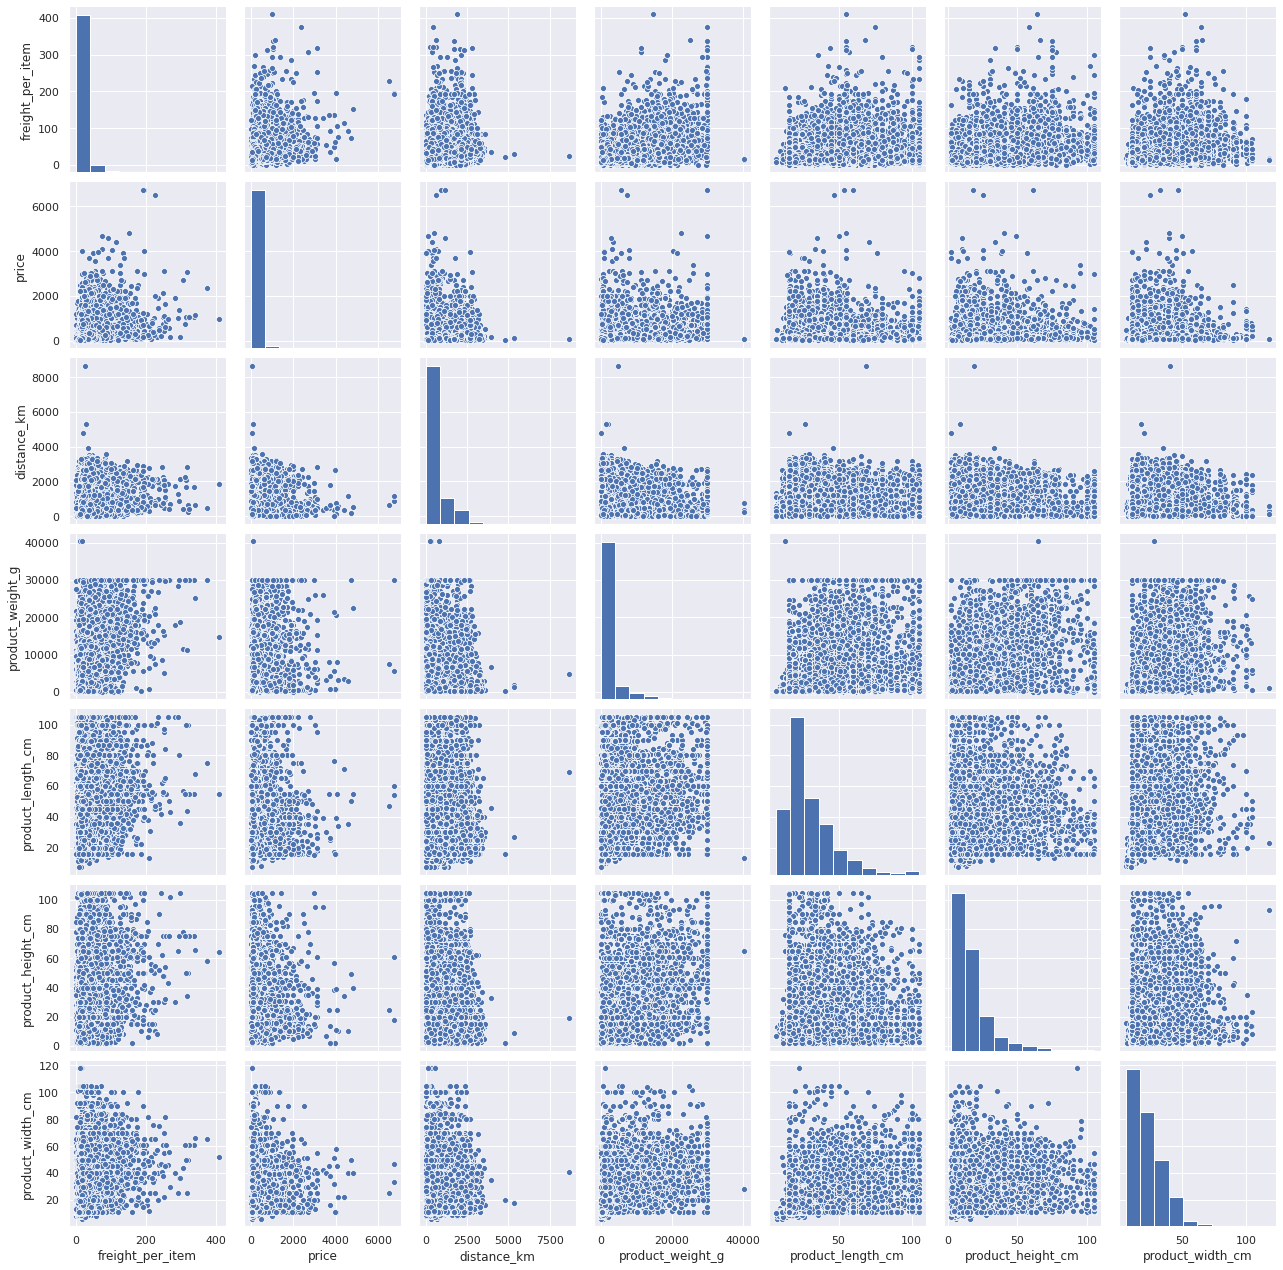

In [ ]:
# Pairplot to visualize the relationship between variables

sns.pairplot(product_freight)

### Outliers & Missing values
We see that shipping distance, freight value and product weight have outliers while the dimensions in cm of products do not have abnormal values. So in cleaning data, we will consider removing outliers from the first 3 variables only.

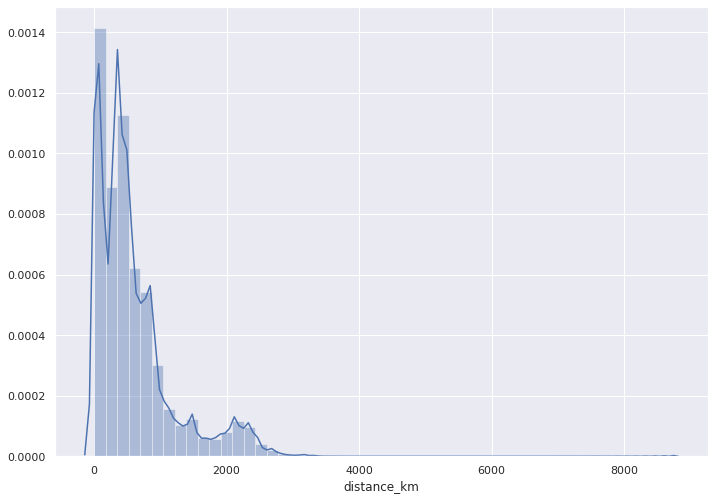

In [ ]:
sns.distplot(product_freight["distance_km"])

In [ ]:
clean_data = product_freight.loc[:, product_freight.columns != "product_id"]

In [ ]:
clean_data.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

freight_per_item   price  ...  product_height_cm  product_width_cm
0.01          1.704542    9.99  ...                2.0              11.0
0.05          5.585000   17.00  ...                3.0              11.0
0.10          7.650000   23.80  ...                4.0              12.0
0.25         11.785000   39.90  ...                8.0              15.0
0.50         15.560000   74.99  ...               13.0              20.0
0.75         20.020000  134.90  ...               20.0              30.0
0.90         31.360000  229.80  ...               31.0              40.0
0.95         43.590000  349.90  ...               45.0              45.0
0.99         82.530400  890.00  ...               65.0              62.0

[9 rows x 7 columns]

In [ ]:
# Remove outliers
low = .01
high = .99

quant_df = clean_data.quantile([low, high])
quant_df.head()

freight_per_item   price  ...  product_height_cm  product_width_cm
0.01          1.704542    9.99  ...                2.0              11.0
0.99         82.530400  890.00  ...               65.0              62.0

[2 rows x 7 columns]

In [ ]:
# Remove rows with at least 1 outlier. This way, we may lose many observations

clean_data = clean_data.loc[(clean_data["freight_per_item"] > quant_df.loc[low, "freight_per_item"]) &
                            (clean_data["freight_per_item"] < quant_df.loc[high, "freight_per_item"]) &
                            (clean_data["distance_km"] > quant_df.loc[low, "distance_km"]) &
                            (clean_data["distance_km"] < quant_df.loc[high, "distance_km"]) &
                            (clean_data["product_weight_g"] > quant_df.loc[low, "product_weight_g"]) &
                            (clean_data["product_weight_g"] < quant_df.loc[high, "product_weight_g"])]


In [ ]:
# Create a new variable which is total dimension of the product

clean_data["total_dimension"] = clean_data["product_length_cm"] + clean_data["product_height_cm"] + clean_data["product_width_cm"]

In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105878 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   freight_per_item   105878 non-null  float64
 1   price              105878 non-null  float64
 2   distance_km        105878 non-null  float64
 3   product_weight_g   105878 non-null  float64
 4   product_length_cm  105878 non-null  float64
 5   product_height_cm  105878 non-null  float64
 6   product_width_cm   105878 non-null  float64
 7   total_dimension    105878 non-null  float64
dtypes: float64(8)
memory usage: 7.3 MB


In [ ]:
clean_data.describe()

freight_per_item          price  ...  product_width_cm  total_dimension
count     105878.000000  105878.000000  ...     105878.000000    105878.000000
mean          17.609447     114.916243  ...         22.780228        68.927246
std           10.547300     159.885888  ...         11.316747        29.224437
min            1.706667       0.850000  ...          6.000000        20.000000
25%           11.850000      39.900000  ...         15.000000        46.000000
50%           15.560000      74.900000  ...         20.000000        60.000000
75%           19.660000     129.990000  ...         30.000000        87.000000
max           82.500000    4099.990000  ...        118.000000       234.000000

[8 rows x 8 columns]

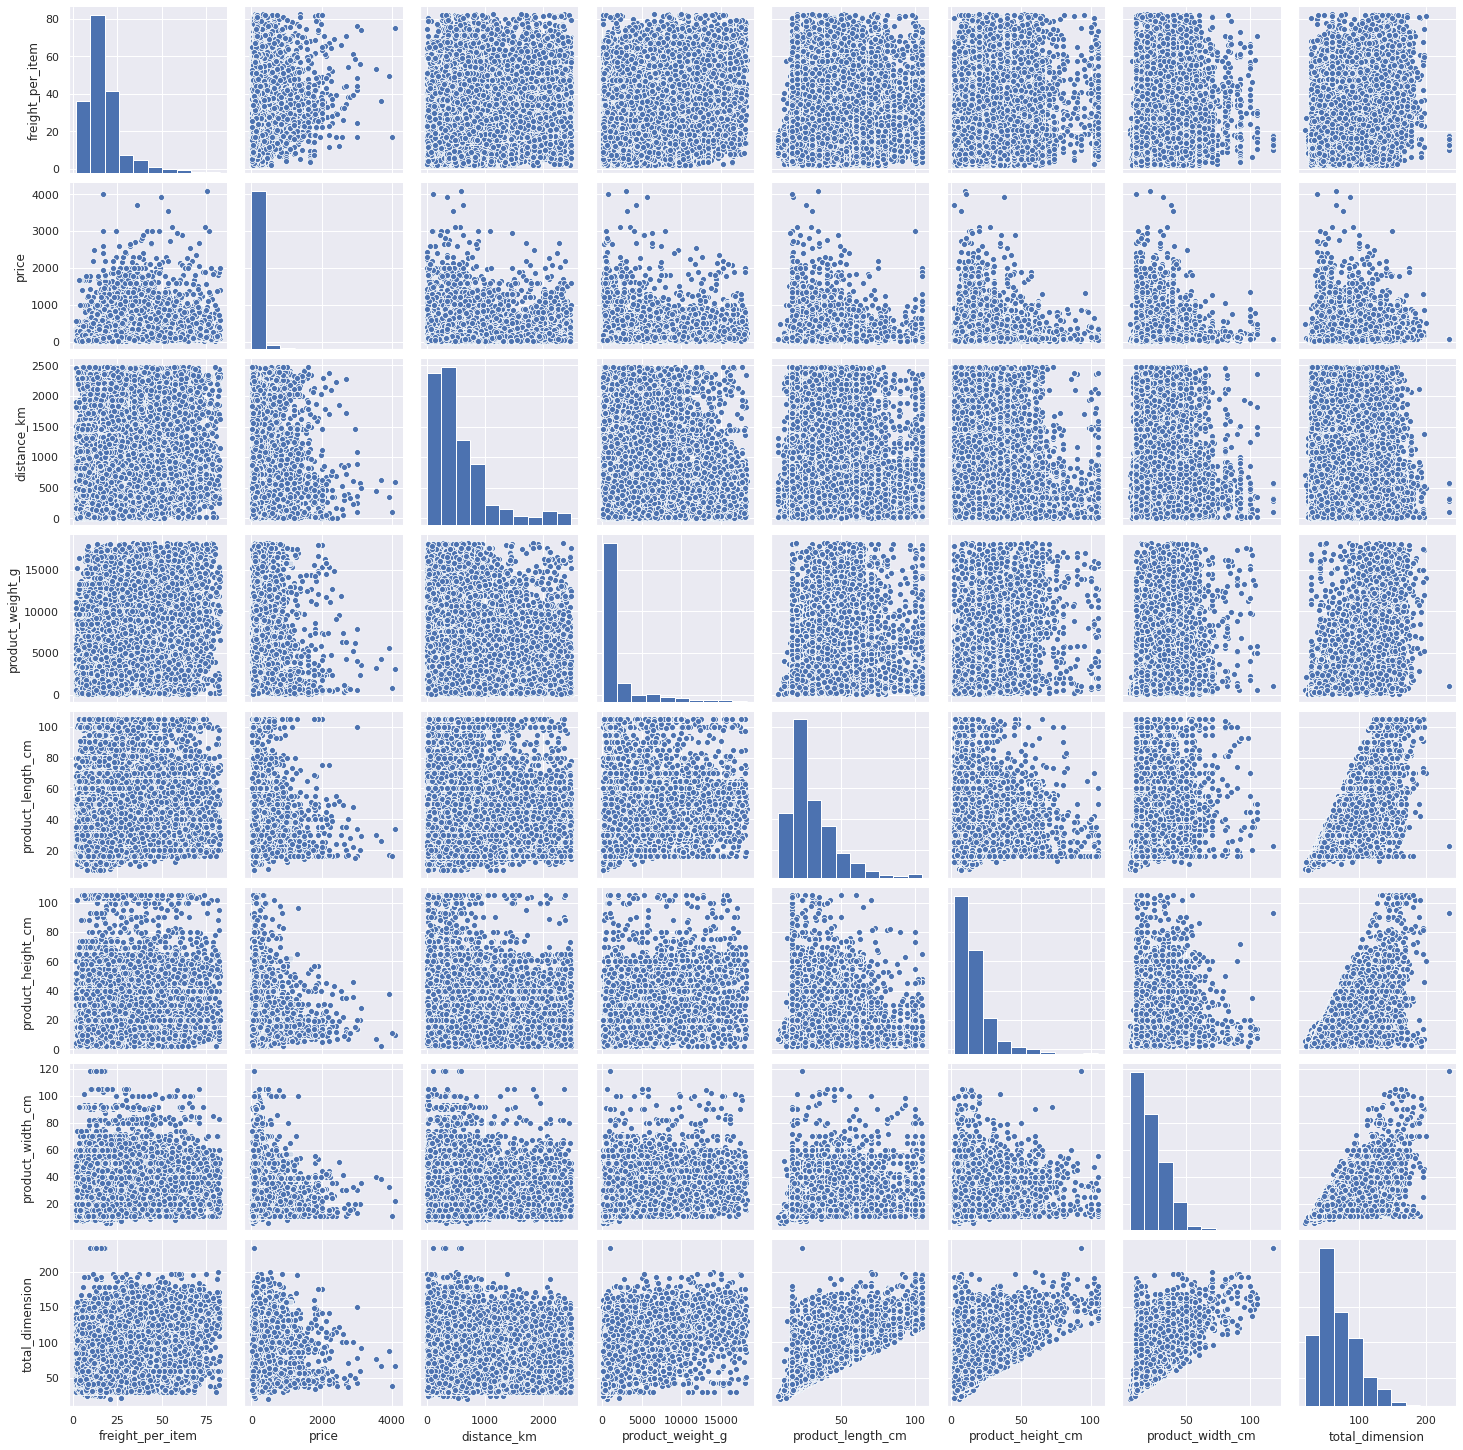

In [ ]:
sns.pairplot(clean_data)

### Correlation Matrix

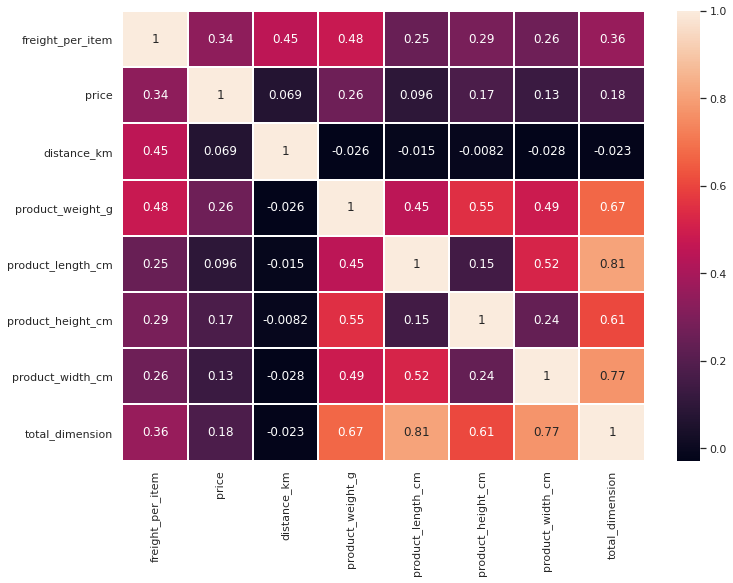

In [ ]:
## Check correlation to see if we have multicollinearity

sns.heatmap(clean_data.corr(), linewidth=1, annot=True)

## Using Statistical Model

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
clean_data.head()

freight_per_item   price  ...  product_width_cm  total_dimension
0             13.29   58.90  ...              14.0             51.0
2             17.87  199.00  ...              33.0             79.0
3             12.79   12.99  ...              15.0             41.0
4             18.14  199.90  ...              30.0            105.0
5             12.69   21.90  ...              15.0             47.0

[5 rows x 8 columns]

#### With distance and product weight

As they are the ones with highest correlation coefficients with the dependent variable.

In [ ]:
# Run with other predictors as well
X = clean_data.loc[:, ["distance_km","product_weight_g"]]
y = clean_data["freight_per_item"]

In [ ]:
## Run a linear regression with the above predictors

X2 = sm.add_constant(X)
# X2 = X
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       freight_per_item   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 2.510e+04
Date:                Sun, 27 Sep 2020   Prob (F-statistic):               0.00
Time:                        06:40:53   Log-Likelihood:            -3.6436e+05
No. Observations:              105878   AIC:                         7.287e+05
Df Residuals:                  105873   BIC:                         7.288e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.6674      0.072  

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif

VIF Factor          features
0    9.641277             const
1    1.080601             price
2    1.007015       distance_km
3    1.894391  product_weight_g
4    1.820063   total_dimension

In [ ]:
# Visualize the predicted and actual values



### Without product length in cm


In [ ]:
X = clean_data.loc[:, ["price","distance_km","product_weight_g","product_length_cm","total_dimension"]]
y = clean_data["freight_per_item"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       freight_per_item   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 2.008e+04
Date:                Sun, 27 Sep 2020   Prob (F-statistic):               0.00
Time:                        06:41:32   Log-Likelihood:            -3.6436e+05
No. Observations:              105878   AIC:                         7.287e+05
Df Residuals:                  105872   BIC:                         7.288e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.6752      0.07

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif

VIF Factor           features
0    9.716946              const
1    1.082479              price
2    1.007041        distance_km
3    1.973670   product_weight_g
4    3.017344  product_length_cm
5    4.379490    total_dimension

### Without product dimension

In [ ]:
X = clean_data.loc[:, ["price","distance_km","product_weight_g"]]
y = clean_data["freight_per_item"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:       freight_per_item   R-squared (uncentered):                   0.807
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                          1.475e+05
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                        0.00
Time:                        06:42:16   Log-Likelihood:                     -3.8310e+05
No. Observations:              105878   AIC:                                  7.662e+05
Df Residuals:                  105875   BIC:                                  7.662e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor          features
0    1.497537             price
1    1.318603       distance_km
2    1.366137  product_weight_g

## Using sklearn

### Running with only the product weight and distance

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
clean_data.head()

freight_per_item   price  ...  product_width_cm  total_dimension
0             13.29   58.90  ...              14.0             51.0
2             17.87  199.00  ...              33.0             79.0
3             12.79   12.99  ...              15.0             41.0
4             18.14  199.90  ...              30.0            105.0
5             12.69   21.90  ...              15.0             47.0

[5 rows x 8 columns]

In [ ]:
x = clean_data.loc[:, ["distance_km","product_weight_g"]]
y = clean_data[["freight_per_item"]]

In [ ]:
# Split data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)


# The function to call linear regression on the train set
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Coefficients: ", lm.coef_)
print("Intercept: ", lm.intercept_)

# Use the trained model to predict on the test set and calculate the R^2 score on this test set.
result = lm.predict(x_test)
print('R^2 on test set: ', metrics.r2_score(y_test, result))
print('MSE on test set: ', metrics.mean_squared_error(y_test,result))

Coefficients:  [[0.00893941 0.00177531]]
Intercept:  [9.13855229]
R^2:  0.4506588124800618
MSE:  61.44053989382285


### Running again with an additional variable

Assume that we think the square root of distance is also important. Let's run the regression again to see if the model is improved.

In [ ]:
clean_data["distance_sqrt"] = np.sqrt(clean_data["distance_km"])

In [ ]:
x = clean_data.loc[:, ["distance_km","distance_sqrt","product_weight_g"]]
y = clean_data[["freight_per_item"]]

# Split data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Coefficients: ", lm.coef_[0])
print("Intercept: ", lm.intercept_)


result = lm.predict(x_test)
print('R^2: ', metrics.r2_score(y_test, result))
print('MSE: ', metrics.mean_squared_error(y_test,result))

Coefficients:  [0.00284565 0.31693464 0.00177023]
Intercept:  [5.89045012]
R^2:  0.45880012123594405
MSE:  60.52998299991516


###  Running a linear regression with all the predictors

In [ ]:
clean_data.head()

freight_per_item   price  ...  product_width_cm  distance_sqrt
0             13.29   58.90  ...              14.0      17.363902
2             17.87  199.00  ...              33.0      17.673255
3             12.79   12.99  ...              15.0      17.122173
4             18.14  199.90  ...              30.0      25.419763
5             12.69   21.90  ...              15.0      12.722204

[5 rows x 8 columns]

In [ ]:
x = clean_data.loc[:, (clean_data.columns != "freight_per_item")]
y = clean_data[["freight_per_item"]]

# Split data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Coefficients: ", lm.coef_)
print("Intercept: ", lm.intercept_)


result = lm.predict(x_test)
print('R^2: ', metrics.r2_score(y_test, result))
print('MSE: ', metrics.mean_squared_error(y_test,result))

Coefficients:  [[0.01255978 0.0028104  0.00142095 0.02375354 0.02645958 0.02641992
  0.30485074]]
Intercept:  [3.62923661]
R^2:  0.4961452431822473
MSE:  56.353153541449984


Text(0, 0.5, 'Predicted values')

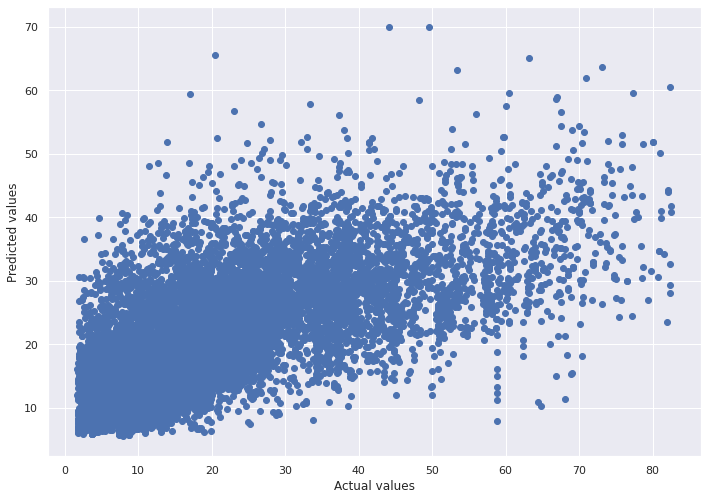

In [ ]:
# Visualize the prediction results
plt.scatter(y_test, result)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

### Checking the residuals

In [ ]:
test_result = pd.concat([x_test, y_test], axis=1)
test_result["y_hat"] = lm.predict(x_test)
test_result["residuals"] = y_test - lm.predict(x_test)

In [ ]:
test_result.head()

price  distance_km  ...      y_hat  residuals
105442   50.00    16.584179  ...   6.553083   2.166917
4480     99.99   228.096743  ...  12.914209   2.995791
86399    99.96   224.929926  ...  24.419943  -3.409943
77670   129.00   138.684063  ...  14.201909   1.808091
19295   158.00  2098.666800  ...  31.539590   1.010410

[5 rows x 10 columns]

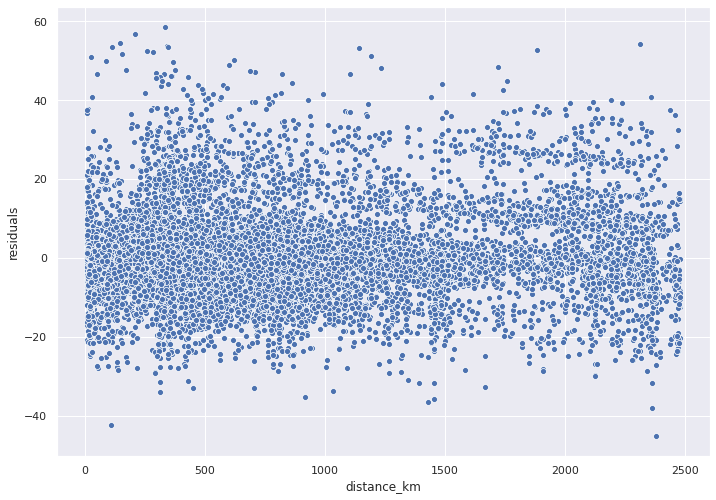

In [ ]:
sns.scatterplot(data=test_result, x="distance_km", y="residuals")

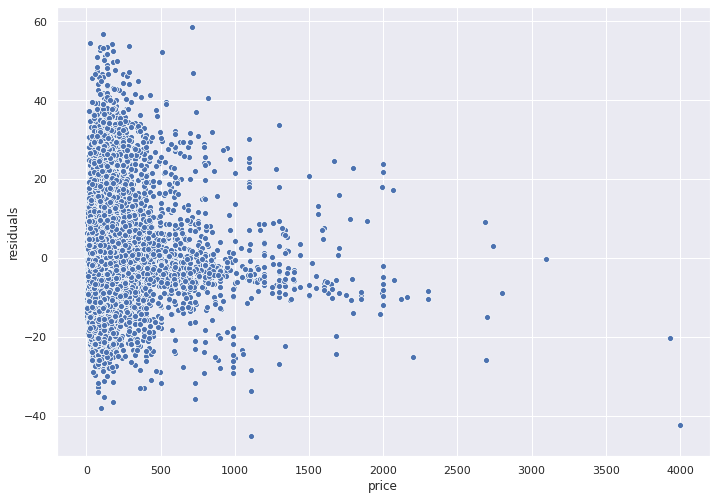

In [ ]:
sns.scatterplot(data=test_result, x="price", y="residuals")

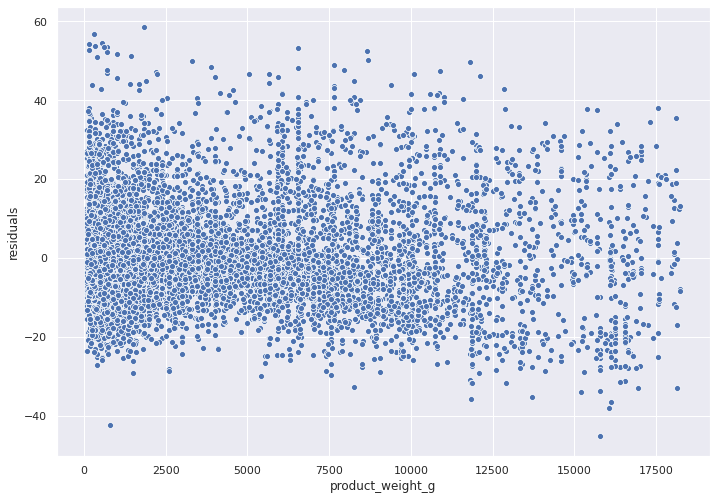

In [ ]:
sns.scatterplot(data=test_result, x="product_weight_g", y="residuals")

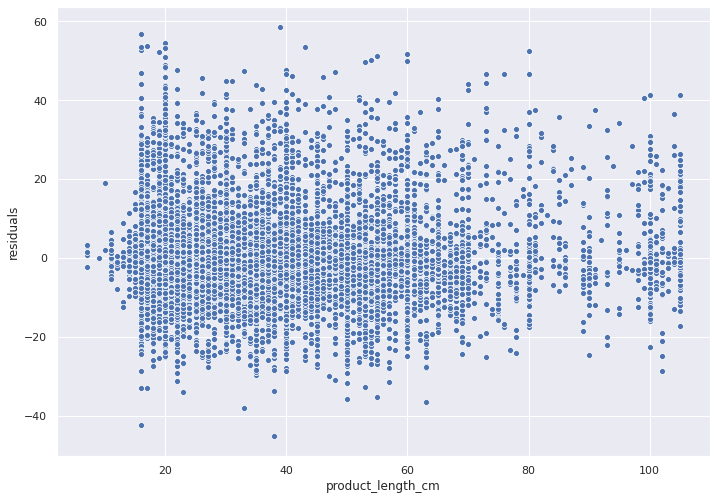

In [ ]:
sns.scatterplot(data=test_result, x="product_length_cm", y="residuals")

## Feature Selection
https://scikit-learn.org/stable/modules/feature_selection.html